<a href="https://colab.research.google.com/github/jorgeluisgonzalezjr/deepLearning_pipeline_project/blob/main/youtube_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install google-api-python-client pandas numpy tqdm langdetect scikit-learn
!pip -q install transformers torch sentencepiece tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# 1. Install the library (usually pre-installed in Colab, but this ensures it)
#!pip install --upgrade google-api-python-client

# 2. The Imports
import re, csv, time
import numpy as np
import pandas as pd
from tqdm import tqdm

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42

import torch
import torch.nn.functional as F
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from google.colab import userdata


In [ ]:
from googleapiclient.discovery import build
try:
    #Enter API key
    api_key = userdata.get('YOUTUBE_KEY')

    # Create the youtube service object
    youtube = build('youtube', 'v3', developerKey=api_key)

    print("✅ Successfully connected to YouTube API!")

except Exception as e:
    print(f"❌ Error: {e}")
    print("Double check that your Secret Name matches the code exactly.")

✅ Successfully connected to YouTube API!


In [ ]:
def save_all_video_comments(video_id, max_total=5000):
    request = youtube.videos().list(part="snippet", id=video_id)
    response = request.execute()

    if not response.get("items"):
        print("Video not found!")
        return None

    title = response["items"][0]["snippet"]["title"]
    clean_title = re.sub(r'[\\/*?:"<>|]', '_', title)
    filename = f"{clean_title}_comments.csv"
    print(f"File Name: {filename}")

    comments_data = []
    next_page_token = None
    seen_comment_ids = set()

    print("🚀 Starting download (Parents + Replies)...")

    while True:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token,
            textFormat="plainText"
        )
        response = request.execute()
        items = response.get("items", [])
        if not items:
            break

        for item in items:
            # Parent
            top_comment = item["snippet"]["topLevelComment"]
            c_id = top_comment["id"]
            c_text = top_comment["snippet"].get("textDisplay", "")

            if c_id not in seen_comment_ids:
                seen_comment_ids.add(c_id)
                comments_data.append([c_text])

            # Replies
            if "replies" in item:
                for reply in item["replies"].get("comments", []):
                    r_id = reply["id"]
                    r_text = reply["snippet"].get("textDisplay", "")
                    if r_id not in seen_comment_ids:
                        seen_comment_ids.add(r_id)
                        comments_data.append([f"[Reply] {r_text}"])

        print(f"   ... collected {len(comments_data)} total comments")

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

        if len(comments_data) >= max_total:
            print("⚠️ Safety Limit Reached.")
            break

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["comment_text"])
        writer.writerows(comments_data)

    print(f"✅ DONE! Saved {len(comments_data)} comments to '{filename}'")
    return filename

VIDEO_ID = "vXrpFxHfppI"
COMMENTS_CSV = save_all_video_comments(VIDEO_ID, max_total=5000)
COMMENTS_CSV


File Name: King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments.csv
🚀 Starting download (Parents + Replies)...
   ... collected 116 total comments
   ... collected 225 total comments
   ... collected 341 total comments
   ... collected 454 total comments
   ... collected 568 total comments
   ... collected 680 total comments
   ... collected 792 total comments
   ... collected 926 total comments
   ... collected 1035 total comments
   ... collected 1172 total comments
   ... collected 1287 total comments
   ... collected 1398 total comments
   ... collected 1511 total comments
   ... collected 1630 total comments
   ... collected 1752 total comments
   ... collected 1865 total comments
   ... collected 1974 total comments
   ... collected 2106 total comments
   ... collected 2242 total comments
   ... collected 2360 total comments
   ... collected 2484 total comments
   ... collected 2613 total comments
   ... collected 2733 total comments
   ..

'King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments.csv'

load + basic transform

In [ ]:
df = pd.read_csv(COMMENTS_CSV)
df = df.rename(columns={"comment_text": "text"})
df["text"] = df["text"].astype(str)

df["is_reply"] = df["text"].str.startswith("[Reply]").astype(int)
df["text"] = df["text"].str.replace(r"^\[Reply\]\s*", "", regex=True)

df.head()



,text,is_reply
0,The full album is a fck masterpiece 😭😭,0
1,😊,0
2,They have certainly grown up… love their music...,0
3,音楽評論家の渋谷陽一さんは否定的でしたが、僕は好きです。\nこのアルバムは僕には絶対です！,0
4,No.,0


basic cleanup/normalize

In [ ]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
WS_RE = re.compile(r"\s+")
REPEAT_CHAR_RE = re.compile(r"(.)\1{3,}")  # looooool -> loool
NON_TEXT_RE = re.compile(r"[^a-zA-Z0-9\s'.,!?$%#@:/()-]")

def normalize_text(s: str) -> str:
    s = str(s).replace("\n", " ").replace("\r", " ").strip()
    s = URL_RE.sub(" URL ", s)
    s = s.lower()
    s = REPEAT_CHAR_RE.sub(r"\1\1\1", s)
    s = NON_TEXT_RE.sub(" ", s)
    s = WS_RE.sub(" ", s).strip()
    return s

def is_english(s: str) -> bool:
    try:
        return detect(s) == "en"
    except:
        return False

df["text_norm"] = df["text"].map(normalize_text)

# drop empties/short
df = df[df["text_norm"].str.len() >= 3].copy()

# drop duplicates
df = df.drop_duplicates(subset=["text_norm"]).copy()

# drop url-only
df = df[~df["text_norm"].str.fullmatch(r"(url\s*)+")].copy()

# token length filter
df["token_len"] = df["text_norm"].str.split().map(len)
df = df[df["token_len"] >= 2].copy()

# Optional English-only (recommended for best label quality)
KEEP_ENGLISH_ONLY = True
if KEEP_ENGLISH_ONLY:
    df["is_en"] = df["text_norm"].apply(is_english)
    df = df[df["is_en"]].copy()
else:
    df["is_en"] = np.nan

df = df.reset_index(drop=True)
df.shape



(2828, 5)

brand safety labelling

In [ ]:
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tox_model_name = "unitary/toxic-bert"
tox_tokenizer = AutoTokenizer.from_pretrained(tox_model_name)
tox_model = AutoModelForSequenceClassification.from_pretrained(tox_model_name).to(device_torch)
tox_model.eval()

tox_labels = [
    "toxicity",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

def toxicity_scores(texts, batch_size=32, max_len=128):
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tox_tokenizer(
            batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
        ).to(device_torch)
        with torch.no_grad():
            logits = tox_model(**inputs).logits
            probs = torch.sigmoid(logits)
        all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

tox = toxicity_scores(df["text_norm"].tolist(), batch_size=32)

for i, lbl in enumerate(tox_labels):
    df[f"tox_{lbl}"] = tox[:, i]

def is_brand_unsafe(row):
    # high-precision defaults
    if row["tox_severe_toxicity"] > 0.50: return 1
    if row["tox_threat"] > 0.40: return 1
    if row["tox_identity_hate"] > 0.40: return 1
    if row["tox_obscene"] > 0.60: return 1
    if row["tox_toxicity"] > 0.75: return 1
    return 0

df["brand_unsafe"] = df.apply(is_brand_unsafe, axis=1).astype(int)
df["brand_safe"] = (1 - df["brand_unsafe"]).astype(int)

df["brand_safe"].value_counts()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 89/89 [15:00<00:00, 10.12s/it]


,count
brand_safe,
1,2729
0,99


spam labelling

In [ ]:
SPAM_KEYWORDS = [
    "subscribe", "sub back", "check my channel", "visit my", "my channel",
    "free", "giveaway", "win", "promo", "discount", "telegram", "whatsapp",
    "crypto", "bitcoin", "invest", "profit", "forex", "signal",
    "click", "link", "dm me", "contact me"
]

def spam_heuristic_score(s: str) -> float:
    score = 0.0
    url_count = len(re.findall(r"\burl\b", s))
    score += 1.5 * min(url_count, 2)
    hits = sum(1 for kw in SPAM_KEYWORDS if kw in s)
    score += 0.6 * min(hits, 6)
    score += 0.15 * min(s.count("!"), 12)

    tokens = s.split()
    if len(tokens) >= 6:
        unique_ratio = len(set(tokens)) / len(tokens)
        if unique_ratio < 0.5:
            score += 1.0

    if len(tokens) <= 4 and ("url" in s or "subscribe" in s or "telegram" in s):
        score += 1.5

    return score

df["spam_heur_score"] = df["text_norm"].apply(spam_heuristic_score)

hf_device = 0 if torch.cuda.is_available() else -1
zero_shot = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=hf_device
)
SPAM_LABELS = ["spam", "not spam"]

def spam_model_prob(texts, batch_size=16):
    probs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        out = zero_shot(batch, candidate_labels=SPAM_LABELS)
        for o in out:
            label2score = dict(zip(o["labels"], o["scores"]))
            probs.append(label2score.get("spam", 0.0))
    return np.array(probs)

df["spam_model_prob"] = spam_model_prob(df["text_norm"].tolist(), batch_size=16)

def is_spam(heur, prob, heur_th=2.2, prob_th=0.85):
    return (prob >= prob_th) or (heur >= heur_th)

df["is_spam"] = [int(is_spam(h, p)) for h, p in zip(df["spam_heur_score"], df["spam_model_prob"])]
df["is_spam"].value_counts()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

100%|██████████| 177/177 [1:11:21<00:00, 24.19s/it]


,count
is_spam,
0,2818
1,6


sentiment labelling

In [ ]:
sentiment = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=hf_device
)

def sentiment_batch(texts, batch_size=32):
    labels, confs = [], []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        out = sentiment(batch)
        for o in out:
            labels.append(o["label"].lower())  # positive/neutral/negative
            confs.append(float(o["score"]))
    return np.array(labels), np.array(confs)

# sentiment only for non-spam
nonspam_mask = df["is_spam"] == 0
df_nonspam = df[nonspam_mask].copy().reset_index(drop=True)

raw_lab, raw_conf = sentiment_batch(df_nonspam["text_norm"].tolist(), batch_size=32)
df_nonspam["sent_label_raw"] = raw_lab
df_nonspam["sent_conf"] = raw_conf

def finalize_sentiment(label, conf, posneg_th=0.80):
    if label in ["positive", "negative"] and conf >= posneg_th:
        return label
    return "neutral"

df_nonspam["label_name"] = [
    finalize_sentiment(l, c, posneg_th=0.80) for l, c in zip(df_nonspam["sent_label_raw"], df_nonspam["sent_conf"])
]

# spam rows
df_spam = df[~nonspam_mask].copy()
df_spam["sent_label_raw"] = None
df_spam["sent_conf"] = None
df_spam["label_name"] = "spam"

# merge back
df_final = pd.concat([df_nonspam, df_spam], ignore_index=True)

df_final["label_name"].value_counts()


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

100%|██████████| 89/89 [06:44<00:00,  4.55s/it]
/tmp/ipython-input-319020330.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_nonspam, df_spam], ignore_index=True)


,count
label_name,
neutral,1475
positive,1062
negative,285
spam,6


label mapping for training and saving

In [ ]:
label_map = {"negative": 0, "neutral": 1, "positive": 2, "spam": 3}

df_final["label"] = df_final["label_name"].map(label_map).astype(int)

# You can choose to only train on brand_safe comments if you want:
TRAIN_SAFE_ONLY = False
if TRAIN_SAFE_ONLY:
    df_model = df_final[df_final["brand_safe"] == 1].copy()
else:
    df_model = df_final.copy()

# Keep only what you need for modeling + analysis
df_model = df_model[[
    "text", "text_norm", "is_reply",
    "brand_safe", "brand_unsafe",
    "tox_toxicity", "tox_severe_toxicity", "tox_obscene", "tox_threat", "tox_insult", "tox_identity_hate",
    "spam_heur_score", "spam_model_prob", "is_spam",
    "sent_label_raw", "sent_conf",
    "label_name", "label"
]].reset_index(drop=True)

print(df_model["label_name"].value_counts())
df_model.to_csv("final_labeled_dataset.csv", index=False)
df_model.head()


label_name
neutral     1475
positive    1062
negative     285
spam           6
Name: count, dtype: int64


,text,text_norm,is_reply,brand_safe,brand_unsafe,tox_toxicity,tox_severe_toxicity,tox_obscene,tox_threat,tox_insult,tox_identity_hate,spam_heur_score,spam_model_prob,is_spam,sent_label_raw,sent_conf,label_name,label
0,The full album is a fck masterpiece 😭😭,the full album is a fck masterpiece,0,1,0,0.084131,0.000674,0.031285,0.000448,0.007327,0.001102,0.0,0.086141,0,positive,0.924114,positive,2
1,They have certainly grown up… love their music...,they have certainly grown up love their music ...,0,1,0,0.009205,0.000105,0.000382,0.000101,0.000678,0.000346,0.0,0.152647,0,positive,0.972266,positive,2
2,IF YOU DONT FEAR OF DEATH THIS SONG WAS GOOD T...,if you dont fear of death this song was good t...,0,1,0,0.017461,0.000147,0.000479,0.000629,0.000681,0.000486,0.0,0.077319,0,positive,0.972785,positive,2
3,You are now an official member of The Passione…,you are now an official member of the passione,0,1,0,0.002998,0.000096,0.000214,0.000129,0.000224,0.000204,0.0,0.091827,0,neutral,0.609366,neutral,1
4,I wish I could put into words what that song d...,i wish i could put into words what that song d...,0,1,0,0.000595,0.000126,0.000183,0.000129,0.000170,0.000142,0.0,0.135743,0,negative,0.799618,neutral,1


prep dataset

In [ ]:
X = df_model["text_norm"].astype(str).values
y = df_model["label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

MAX_VOCAB = 20000
MAX_LEN = 60

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(X_train)

train_seq = tok.texts_to_sequences(X_train)
test_seq  = tok.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")


train

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
    layers.Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
]

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=32,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.4721 - loss: 1.1405 - val_accuracy: 0.5784 - val_loss: 0.9274
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5423 - loss: 0.9516 - val_accuracy: 0.6556 - val_loss: 0.7852
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7452 - loss: 0.6395 - val_accuracy: 0.6887 - val_loss: 0.7740
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8970 - loss: 0.3362 - val_accuracy: 0.7042 - val_loss: 0.8534
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9439 - loss: 0.1824 - val_accuracy: 0.6976 - val_loss: 1.1831


test/predict, visualize confusion matrix

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
              precision    recall  f1-score   support

    negative       0.64      0.40      0.49        57
     neutral       0.75      0.68      0.72       295
    positive       0.65      0.79      0.71       213
        spam       0.00      0.00      0.00         1

    accuracy                           0.70       566
   macro avg       0.51      0.47      0.48       566
weighted avg       0.70      0.70      0.69       566



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


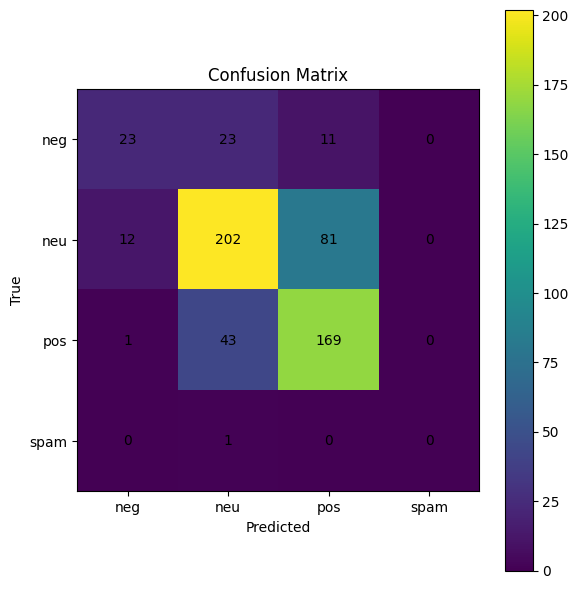

In [ ]:
pred = model.predict(X_test_pad)
y_pred = pred.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=["negative","neutral","positive","spam"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(4)
plt.xticks(ticks, ["neg","neu","pos","spam"])
plt.yticks(ticks, ["neg","neu","pos","spam"])
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
!pip install better_profanity
from better_profanity import profanity
import pandas as pd

# 1. Load your dataset again (just to be fresh)
# Make sure 'df' is loaded from your previous step!
# 1. Load the CSV from previous cell
filename = "/content/King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments.csv"
df = pd.read_csv(filename)

# 2. Define your Scam/Spam keywords (The "Commercial" Risk)
spam_keywords = [
    'whatsapp', 'telegram', 'investment', 'crypto', 'forex',
    'manager', 'profit', 'usdt', 'bitcoin', 'passive income',
    'click here', 'dm me', 'inbox me'
]

# 3. The Master Function
def check_brand_safety(comment):
    # Convert to string (just in case) and lower case
    text = str(comment).lower()

    # Is it Spam?
    for word in spam_keywords:
        if word in text:
            return 1 # Unsafe (Spam)

    # CHECK 2: Is it Profanity?
    # This library checks against a huge list of bad words automatically
    if profanity.contains_profanity(text):
        return 1 # Unsafe (Profanity)

    return 0 # Safe / Family Friendly

# 4. Apply it
print("Labels dataset for Brand Safety...")
df['label'] = df['comment_text'].apply(check_brand_safety)

# 5. Check the breakdown
print("\n--- Brand Safety Report ---")
safety_counts = df['label'].value_counts()
print(safety_counts)

print(f"\nWe found {safety_counts.get(1, 0)} Unsafe comments and {safety_counts.get(0, 0)} Safe comments.")

# 6. Preview the "Unsafe" ones to verify
print("\n--- Preview of Flagged Content ---")
# displaying only the text and label
display(df[df['label'] == 1][['comment_text', 'label']].head(10))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.3 MB/s eta 0:00:00
Labels dataset for Brand Safety...

--- Brand Safety Report ---
label
0    4950
1     169
Name: count, dtype: int64

We found 169 Unsafe comments and 4950 Safe comments.

--- Preview of Flagged Content ---


,comment_text,label
33,"[Reply] Merci d'avoir écrit les paroles, je pe...",1
188,I haven’t seen anyone else comment on this but...,1
197,Stupid fucking mix..all of the good shit is ...,1
220,"[Reply] Like this Album, the Yes Album is like...",1
266,"Amazing voice, great bassline...GREG I FUCKIN ...",1
272,"[Reply] Man you haven’t heard shit yet lol, ta...",1
292,"I've never known my father, I don't even know ...",1
299,Shout out to the manga/anime creators that wer...,1
321,[Reply] If you read the book of Job in the Bib...,1
331,This is god,1


## We need to clean up data we need to give it more than just comments for the model to understand what is going on so my suggestion for this is to add more values to different rows to this csv.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.utils.class_weight import compute_class_weight
import os

# ==========================================
# 0. SETUP VADER (The Social Media Specialist)
# ==========================================
# Download VADER dictionary if missing
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize the VADER engine
sia = SentimentIntensityAnalyzer()

# ==========================================
# 1. LOAD DATA
# ==========================================
input_filename = "King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments.csv"

if not os.path.exists(input_filename):
    print(f"ERROR: The file '{input_filename}' was not found.")
else:
    df = pd.read_csv(input_filename)

    # 2. Define Keywords & Maps
    spam_keywords = ['click my channel', 'click the link', 'subscribe to me', 'check out my video', 'free gift', 'sub 4 sub']
    toxic_keywords = ['stupid', 'hate', 'trash', 'worst', 'kill', 'die', 'idiot', 'ugly']

    # --- ADDED: LABEL MAP ---
    label_map = {
        0: "Negative",
        1: "Neutral",
        2: "Positive",
        3: "Spam"
    }

    # 3. Clean Text
    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(r'\d{1,2}:\d{2}', '', text)
        text = re.sub(r'http\S+', '', text)
        return text.strip()

    df['clean_text'] = df['comment_text'].apply(preprocess_text)

    # 4. Multi-Class Labeling with VADER
    def get_multi_label(text):
        # Priority 1: Check Spam (3)
        if any(phrase in text for phrase in spam_keywords): return 3

        # Priority 2: Check Explicit Toxic Words (0)
        if any(word in text for word in toxic_keywords): return 0

        # Priority 3: Check Sentiment using VADER
        score = sia.polarity_scores(str(text))['compound']

        if score < -0.2: return 0       # Negative
        if score > 0.2: return 2        # Positive
        return 1                        # Neutral

    # Create the numeric label (0, 1, 2, 3)
    df['label'] = df['clean_text'].apply(get_multi_label)

    # --- NEW: Create a readable label column using the map ---
    df['label_name'] = df['label'].map(label_map)

    # 5. Calculate Weights
    y_all = df['label'].values
    classes = np.unique(y_all)

    if len(classes) > 1:
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_all)
        weight_dict = dict(zip(classes, weights))
    else:
        weight_dict = {classes[0]: 1.0}

    df['sample_weight'] = df['label'].map(weight_dict)
    print(f"Class Weights Calculated: {weight_dict}")
    print(f"Label Counts:\n{df['label_name'].value_counts()}")

    # 6. Save
    base_name, extension = os.path.splitext(input_filename)
    output_filename = f"{base_name}_multiclass_labeled{extension}"

    # Save, now including the readable 'label_name' column
    df.to_csv(output_filename, index=False)
    print(f"SUCCESS: Labeled data saved to: {output_filename}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Class Weights Calculated: {np.int64(0): np.float64(2.3699074074074074), np.int64(1): np.float64(0.6059422348484849), np.int64(2): np.float64(1.0779111391871974)}
Label Counts:
label_name
Neutral     2816
Positive    1583
Negative     720
Name: count, dtype: int64
SUCCESS: Labeled data saved to: King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments_multiclass_labeled.csv


confusion matrix


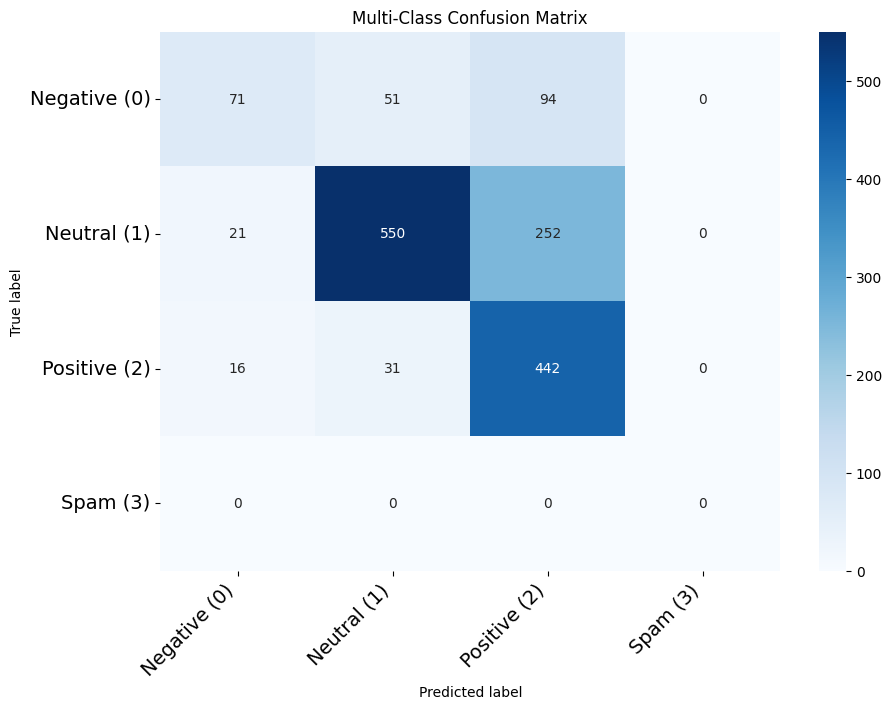

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import re

# 1. Your Visualization Function
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        # Changed cmap to 'Reds' for easier visibility of errors, or stick to 'Blues'
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# 2. Prepare the Data
# Load the Multi-Class Labeled file
filename = "King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments_multiclass_labeled.csv"
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please check the file path.")
    # Stop execution if file not found (simulated with a blank df for safety in this snippet)
    df = pd.DataFrame(columns=['clean_text', 'label'])

# Ensure 'clean_text' exists
if 'clean_text' not in df.columns and not df.empty:
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\d{1,2}:\d{2}', '', text)
        text = re.sub(r'http\S+', '', text)
        return text.strip()
    df['clean_text'] = df['comment_text'].apply(clean_text)

# Drop empty rows
df = df.dropna(subset=['clean_text', 'label'])

if not df.empty:
    # 3. Simulate a Model (Naive Bayes)
    X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.3, random_state=42)

    # Vectorize
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train (Naive Bayes automatically handles multi-class!)
    model = MultinomialNB()
    model.fit(X_train_vec, y_train)

    # 4. Generate Predictions
    y_pred = model.predict(X_test_vec)

    # 5. Plot Confusion Matrix
    # FIX 1: We explicitly list labels [0,1,2,3] so the matrix is always 4x4
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

    # FIX 2: Updated Class Names to match your new data
    class_names = ["Negative (0)", "Neutral (1)", "Positive (2)", "Spam (3)"]

    # Display
    print_confusion_matrix(conf_matrix, class_names)
    plt.title("Multi-Class Confusion Matrix")
    plt.show()
else:
    print("DataFrame is empty. Cannot plot.")

## New Section



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. LOAD & SPLIT
# Load the file we created in Chunk 1
filename = "/content/King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments_with_weights_and_labels.csv"
df = pd.read_csv(filename)

# Split into Train and Test (Standard Step for modeling)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    df['clean_text'],       # X: Input
    df['brand_value'],      # y: Target
    df['sample_weight'],    # w: Weights
    test_size=0.3,
    random_state=42
)


# 2. TOKENIZATION (The LSTM Input)
VOCAB_SIZE = 5000       # Vocabulary size
MAX_LENGTH = 100        # Max words per comment
OOV_TOK = "<OOV>"       # Placeholder for unknown words

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)

# Fit on Training Data ONLY (Learn the vocabulary)
# Note: We convert to string just in case any numbers slipped through
tokenizer.fit_on_texts(X_train.astype(str))

# Convert Text to Numbers
train_sequences = tokenizer.texts_to_sequences(X_train.astype(str))
test_sequences = tokenizer.texts_to_sequences(X_test.astype(str))

# Pad Sequences (Ensure all inputs are length 100)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# ==========================================
# 3. VERIFICATION
# ==========================================
print(f"Training Matrix Shape: {train_padded.shape}")
print(f"Testing Matrix Shape:  {test_padded.shape}")
print("-" * 30)
print(f"First Comment (Raw):     {X_train.iloc[0]}")
print(f"First Comment (Tokenized): {train_padded[0]}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/King Crimson - Epitaph (Including _March For No Reason_ and _Tomorrow And Tomorrow_)_comments_with_weights_and_labels.csv'